In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
#importing data
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 97% 596M/612M [00:02<00:00, 261MB/s]
100% 612M/612M [00:02<00:00, 252MB/s]


In [ ]:
!unzip "/content/gtsrb-german-traffic-sign.zip" -d "/content/drive/MyDrive/data sets /traffic_sign_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: /content/drive/MyDrive/data sets /traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: /content/drive/MyDrive/data sets /tr

In [ ]:
# Import the required libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn.model_selection import train_test_split

## Helper Function

In [ ]:
# Some basic parameters
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)

BATCH_SIZE = 32 # inline of Traing Rows being 60000

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [ ]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [ ]:
# Create variables to the folders

train_folder = "/content/drive/MyDrive/data sets /traffic_sign_dataset/Train"
test_folder = "/content/drive/MyDrive/data sets /traffic_sign_dataset/Test"

train_class_folders = os.listdir(train_folder)

# Dictionary for naming the class types

classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

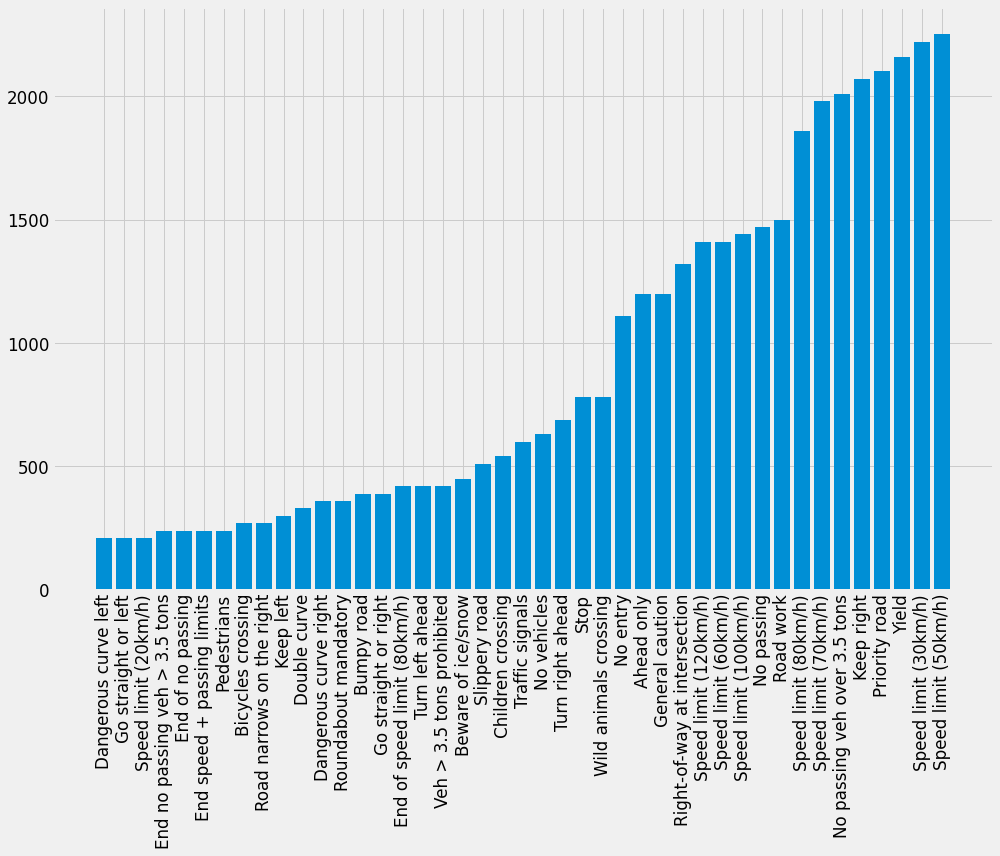

In [ ]:
# Get number of instances per class and visualize the data
train_numberOfInstancesPerClass = []
class_names = []

for folder in train_class_folders:
    train_files = os.listdir(train_folder + '/' + folder)
    train_numberOfInstancesPerClass.append(len(train_files))
    class_names.append(classes[int(folder)])

pairs = zip(train_numberOfInstancesPerClass, class_names)
pairs = sorted(pairs)
tuples = zip(*pairs)
train_numberOfInstancesPerClass, class_names = [
    list(tuple) for tuple in tuples]

plt.bar(class_names, train_numberOfInstancesPerClass)
plt.xticks(class_names, rotation='vertical')
plt.show()

In [ ]:
# Creating image data and label arrs for training/validation sets

images = []
labels = []

for imgClass in range(len(classes)):
    imgFolder_path = train_folder + "/" + str(imgClass)
    imgFolder = os.listdir(imgFolder_path)

    for img in imgFolder:
        image = cv2.imread(imgFolder_path + "/" + img)  # get an image
        image = Image.fromarray(image, 'RGB')
        image = image.resize((32, 32))  # resize all images to same size
        images.append(np.array(image))
        labels.append(imgClass)

images = np.array(images)
labels = np.array(labels)

In [ ]:
# Shuffle the dataset

shuffle_indexes = np.arange(images.shape[0])
np.random.shuffle(shuffle_indexes)
images = images[shuffle_indexes]
labels = labels[shuffle_indexes]

In [ ]:
# Create the training and validation sets 

x_train, x_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.3, shuffle=True)

x_train = x_train/255
x_val = x_val/255  

# Convert classes to one-hot vectors
y_train = keras.utils.to_categorical(y_train, len(classes))
y_val = keras.utils.to_categorical(y_val, len(classes))

In [ ]:
# Load the test data and create the test sets

test_csv = pd.read_csv("/content/drive/MyDrive/data sets /traffic_sign_dataset/Test.csv")

labels = test_csv['ClassId'].values  # y_test
images = test_csv['Path'].values
x_test = []

for imagePath in images:
    image = cv2.imread('/content/drive/MyDrive/data sets /traffic_sign_dataset'+'/' + imagePath)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((32, 32))
    x_test.append(np.array(image))

x_test = np.array(x_test)
x_test = x_test/255

In [ ]:
model1 = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu',
                        input_shape=x_train[0].shape, padding='same'), 
    keras.layers.AveragePooling2D(),  
    
    keras.layers.Conv2D(16, kernel_size=5, strides=1,
                        activation='relu', padding='valid'),
    keras.layers.AveragePooling2D(),
    
    keras.layers.Conv2D(120, kernel_size=5, strides=1,
                        activation='relu', padding='valid'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(84, activation='relu'),
    keras.layers.Dense(43, activation='softmax')  # Output layer. 43 since since there are 43 possible classes.
])

In [ ]:
model1.compile( optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_6 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_7 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 120)         48120     
                                                                 
 flatten_3 (Flatten)         (None, 480)              

In [ ]:
print("x train: " + str(x_train.shape))
print("x validation: "+str(x_val.shape))
print("y train: " + str(y_train.shape))
print("y validation: "+str(y_val.shape))

x train: (27446, 32, 32, 3)
x validation: (11763, 32, 32, 3)
y train: (27446, 43)
y validation: (11763, 43)


In [ ]:
history = model1.fit(x_train, y_train, epochs=10,
                           validation_data=(x_val, y_val))

Epoch 1/10
858/858 [==============================] - 41s 47ms/step - loss: 1.4996 - accuracy: 0.5839 - val_loss: 0.5953 - val_accuracy: 0.8253
Epoch 2/10
858/858 [==============================] - 38s 45ms/step - loss: 0.4201 - accuracy: 0.8774 - val_loss: 0.3637 - val_accuracy: 0.9010
Epoch 3/10
858/858 [==============================] - 38s 45ms/step - loss: 0.2527 - accuracy: 0.9290 - val_loss: 0.2604 - val_accuracy: 0.9321
Epoch 4/10
858/858 [==============================] - 38s 45ms/step - loss: 0.1676 - accuracy: 0.9534 - val_loss: 0.1843 - val_accuracy: 0.9577
Epoch 5/10
858/858 [==============================] - 38s 44ms/step - loss: 0.1303 - accuracy: 0.9628 - val_loss: 0.1638 - val_accuracy: 0.9630
Epoch 6/10
858/858 [==============================] - 38s 44ms/step - loss: 0.1012 - accuracy: 0.9697 - val_loss: 0.1561 - val_accuracy: 0.9665
Epoch 7/10
858/858 [==============================] - 40s 47ms/step - loss: 0.0816 - accuracy: 0.9756 - val_loss: 0.1415 - val_accuracy:

In [ ]:
result_df = pd.DataFrame(history.history) # converting into pandas dataframe
result_df

,loss,accuracy,val_loss,val_accuracy
0,1.499603,0.583910,0.595325,0.825300
1,0.420150,0.877432,0.363729,0.901046
2,0.252693,0.928988,0.260353,0.932075
3,0.167637,0.953363,0.184291,0.957664
4,0.130264,0.962836,0.163794,0.963020
5,0.101180,0.969686,0.156105,0.966505
6,0.081568,0.975552,0.141482,0.971351
7,0.067584,0.980653,0.207367,0.951543
8,0.056211,0.983495,0.145568,0.967695
9,0.052383,0.984916,0.125228,0.975942


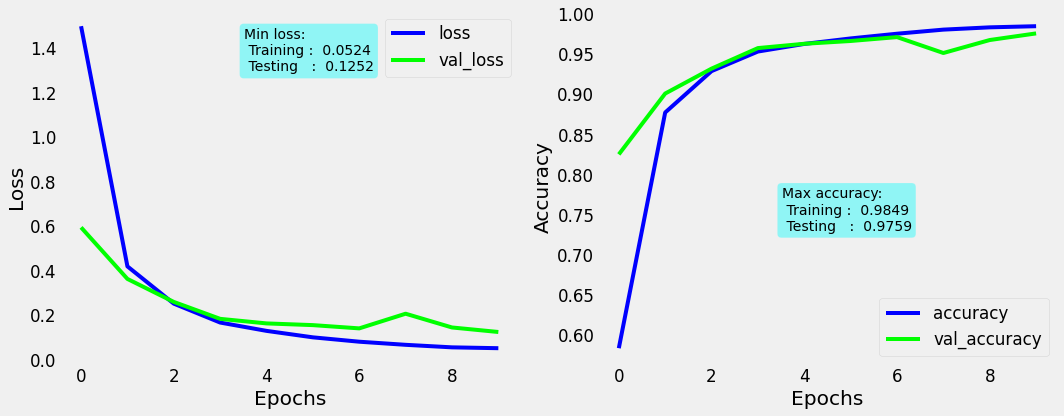

In [ ]:
# plotting the graph of loss and accuracy - using helper functions defined in begining
fn_plot_hist(result_df)

In [ ]:
# Make the prediction with test data

pred = model1.predict(x_test)
pred = np.argmax(pred, axis=1)

# Measure the accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred)*100)

Test Data accuracy:  89.77038796516231


In [ ]:
#saving the model
model1.save("model.h5")

In [ ]:
# saving the weights
model1.save_weights("/content/drive/MyDrive/data sets /traffic_sign_dataset")
